# Prototype calculation of cabelling and mixing of density from CM2.6 data <a class="anchor" id="top"> </a>

In [13]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [14]:
client

<Client: 'tls://10.0.63.23:8786' processes=30 threads=60, memory=900.00 GiB>

In [ ]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
#import gsw

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


## Laplacian routine

In [3]:
wet_mask = coord.wet
dxt = coord.dxt
dyt = coord.dyt
dxu = coord.dxu
dyu = coord.dyu
area_t = coord.area_t
kappa = 10 #m^2/s

In [4]:
grid = xgcm.Grid(ds.drop_dims('time'), coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [5]:
@xgcm.as_grid_ufunc(dask="parallelized")
def Laplacian(
    wet_mask: Annotated[np.ndarray, "(Y:center, X:center)"],
    dxt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    dyt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    area_t:   Annotated[np.ndarray, "(Y:center, X:center)"],
    tracer:   Annotated[np.ndarray, "(Y:center, X:center)"],
    dxu:      Annotated[np.ndarray, "(Y:right, X:right)"],
    dyu:      Annotated[np.ndarray, "(Y:right, X:right)"],
) ->          Annotated[np.ndarray, "(Y:center, X:center)"]:
    
    """Laplacian for MOM5 (tracer points).
    MOM5 uses a Northeast convention B-grid, where velocity point U(i,j) is NE of tracer point T(i,j).
    Attributes
    __________
    For information on MOM5 discretization see: https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf
    wet_mask: Mask array, 1 for ocean, 0 for land
    dxt: width in x of T-cell, model diagnostic dxt
    dyt: height in y of T-cell, model diagnostic dyt
    dxu: width in x of U-cell, model diagnostic dxu
    dyu: height in y of U-cell, model diagnostic dyu
    area_t: area of T-cell, dxt*dyt
    """    
    #x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    #y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)
    y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)

    tracer = np.nan_to_num(tracer)
    
    fx = 2 * (np.roll(tracer, -1, axis=-2) - tracer)
    fx /= dxu + np.roll(dxu, 1, axis=-1)
    fx *= x_wet_mask
    
    fy = 2 * (np.roll(tracer, -1, axis=-1) - tracer)
    fy /= dyu + np.roll(dyu, 1, axis=-2)
    fy *= y_wet_mask

    out1 = fx * 0.5 * (dyt + np.roll(dyt, -1, axis=-2))
    out1 -= (
        np.roll(fx, 1, axis=-2) * 0.5 * (dyt + np.roll(dyt, 1, axis=-2))
    )
    out1 /= area_t

    out2 = fy * 0.5 * (dxt + np.roll(dxt, -1, axis=-1))
    out2 -= (
        np.roll(fy, 1, axis=-1) * 0.5 * (dxt + np.roll(dxt, 1, axis=-1))
    )
    out2 /= area_t
    return out1 + out2

In [6]:
axis = 7*[('Y','X')]

# 1) Calculate tendency of SST and and SSS from mixing <a class="anchor" id="first-bullet"> </a>

In [7]:
sst = surf_ds.surface_temp
sss = surf_ds.surface_salt

In [8]:
SST_lap = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, sst, dxu, dyu, axis=axis)
SSS_lap = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, sss, dxu, dyu, axis=axis)

In [9]:
SSS_lap

<xarray.DataArray (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

# 2) Convert to density tendency <a class="anchor" id='second-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$

In [10]:
rho = xr.apply_ufunc(jmd95numba.rho, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())

In [50]:
rho

<xarray.DataArray (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(7305, 2700, 3600), dtype=float32, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [42]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()
drhods = xr.apply_ufunc(jmd95numba.drhods, sss, sst, 0,
                        output_dtypes=[sss.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load()

In [15]:
dens_tend = (drhodt * SST_lap + drhods * SSS_lap)
dens_tend

<xarray.DataArray (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<add, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

[Back to top](#top)

# 3) Decompose into the following form <a class='anchor' id='third-bullet'> </a>

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) = M(\rho) + C
$$

You can calculate $C$ as

$$
C = \frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) - M(\rho)
$$

In [37]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [38]:
rho_imported = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))

In [47]:
rho_imported_lap_outliers = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, rho_imported.rho.where(wet_mask), dxu, dyu, axis=axis)

In [16]:
rho_lap_outliers = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, rho, dxu, dyu, axis=axis)

rho_lap_outliers

<xarray.DataArray (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

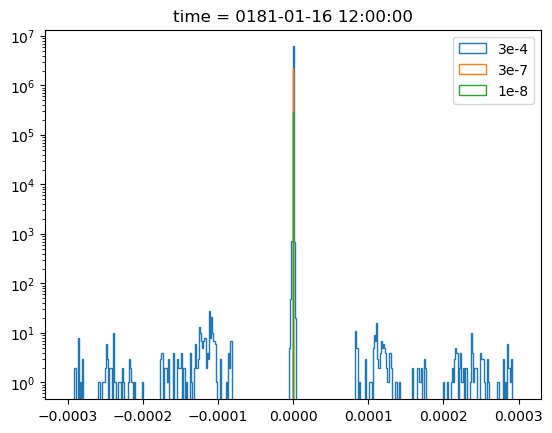

In [21]:
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-4, 3e-4, 400), yscale="log", 
                                       histtype="step", label='3e-4')
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-7, 3e-7, 400), yscale="log", 
                                       histtype="step", label='3e-7')
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-8, 3e-8, 400), yscale="log", 
                                       histtype="step", label='1e-8')
plt.legend();

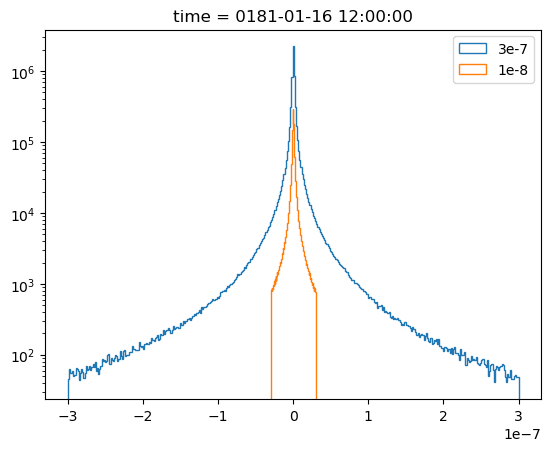

In [22]:
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-7, 3e-7, 400), yscale="log", 
                                       histtype="step", label='3e-7')
rho_lap_outliers[0].where(wet_mask).plot.hist(bins=np.linspace(-3e-8, 3e-8, 400), yscale="log", 
                                       histtype="step", label='1e-8')
plt.legend();

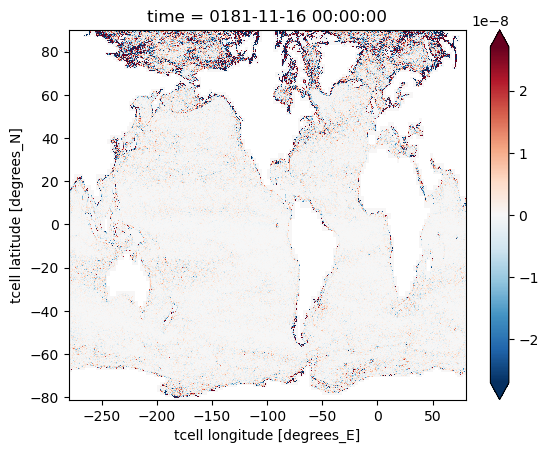

In [19]:
rho_lap_outliers[10].plot(robust=True);

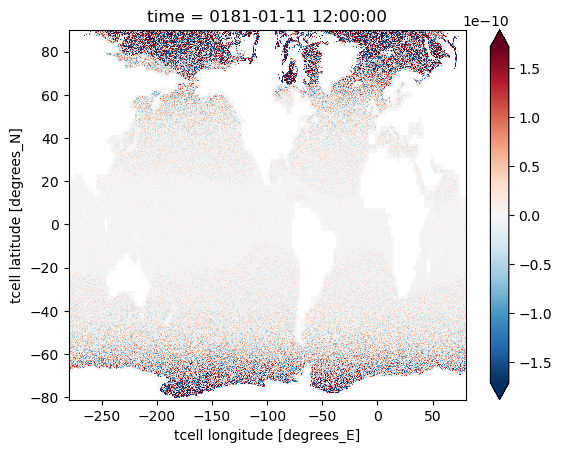

In [48]:
(rho_lap_outliers-rho_imported_lap_outliers)[10].plot(robust=True);

In [17]:
rho_lap = rho_lap_outliers.where(abs(rho_lap_outliers) < 3e-7)

In [40]:
rho_imported_lap = rho_imported_lap_outliers.where(abs(rho_imported_lap_outliers) < 3e-7)

In [18]:
cabbeling = dens_tend - rho_lap

In [19]:
cabbeling

<xarray.DataArray (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<sub, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

In [18]:
selection = dict(xt_ocean=slice(-75,-25), yt_ocean=slice(25,60))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

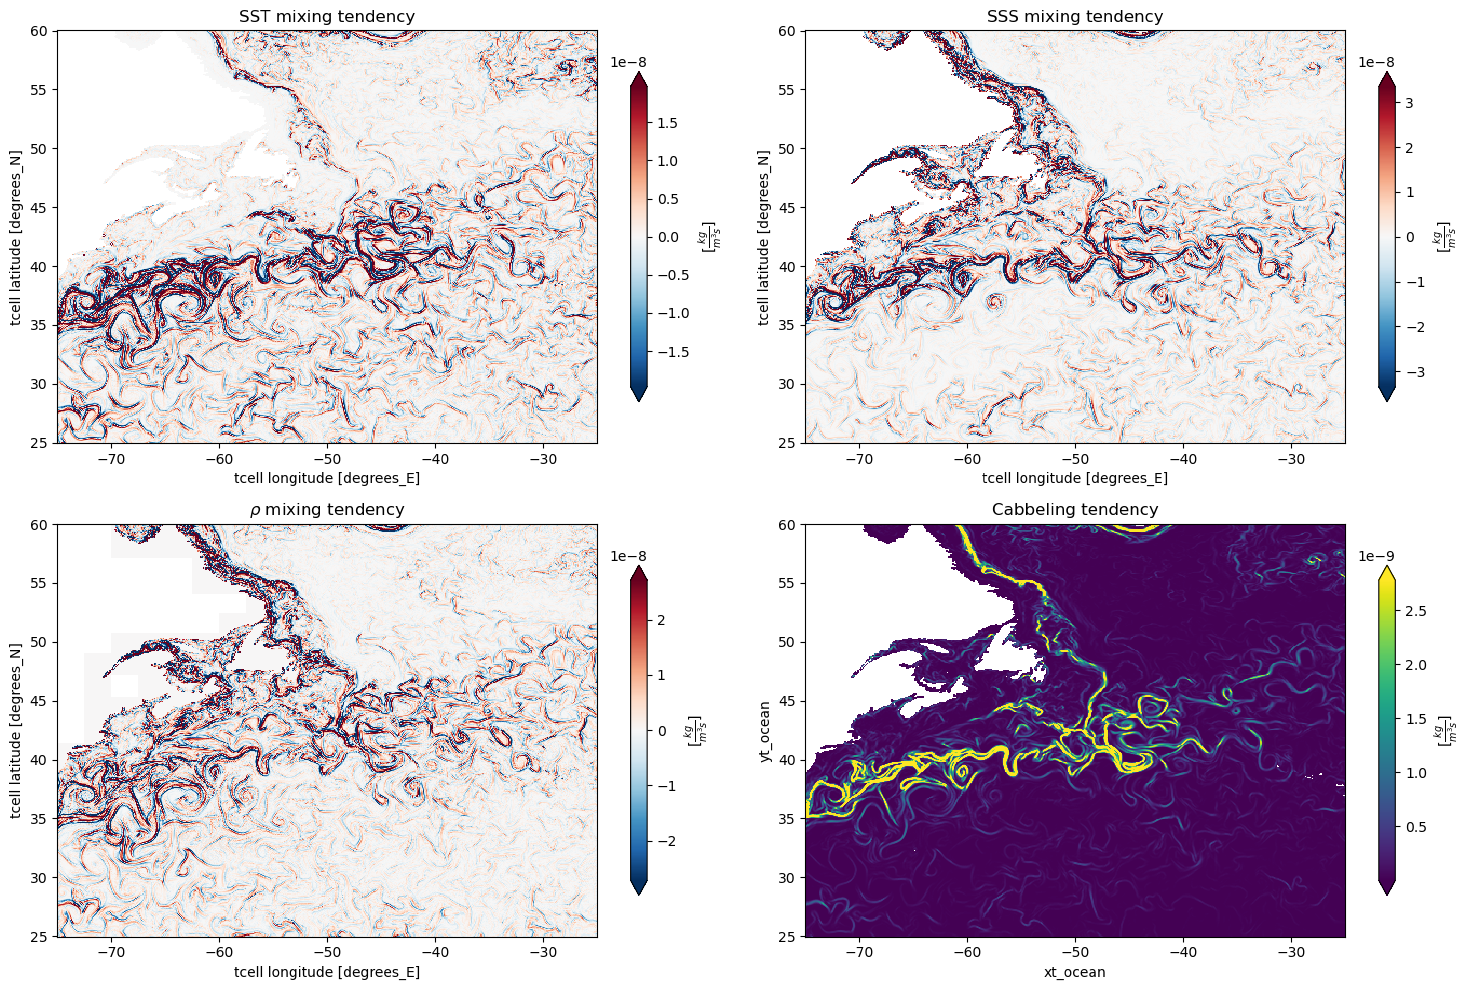

In [21]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(SST_lap*drhodt).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs=kwargs)
ax[0,0].set_title('SST mixing tendency')
(SSS_lap*drhods).isel(time=0).sel(**selection).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs=kwargs)
ax[0,1].set_title('SSS mixing tendency')
(rho_lap).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs=kwargs)
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling).isel(time=0).sel(**selection).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs=kwargs)
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();

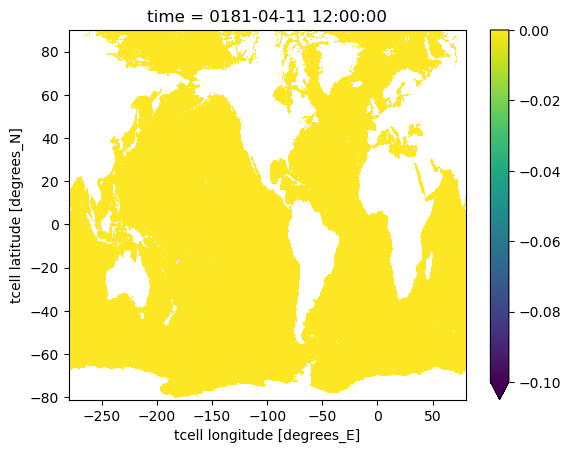

In [20]:
(rho_lap - dens_tend + cabbeling).isel(time=100).plot(robust=True, vmin=1e-10)

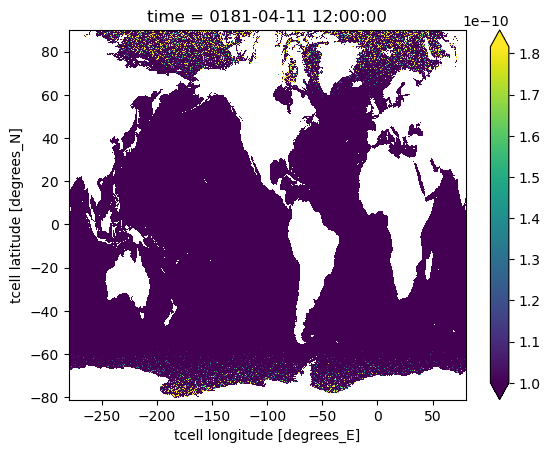

In [44]:
(rho_lap - rho_imported_lap.where(wet_mask)).isel(time=100).plot(robust=True, vmin=1e-10)

# Surface tendencies

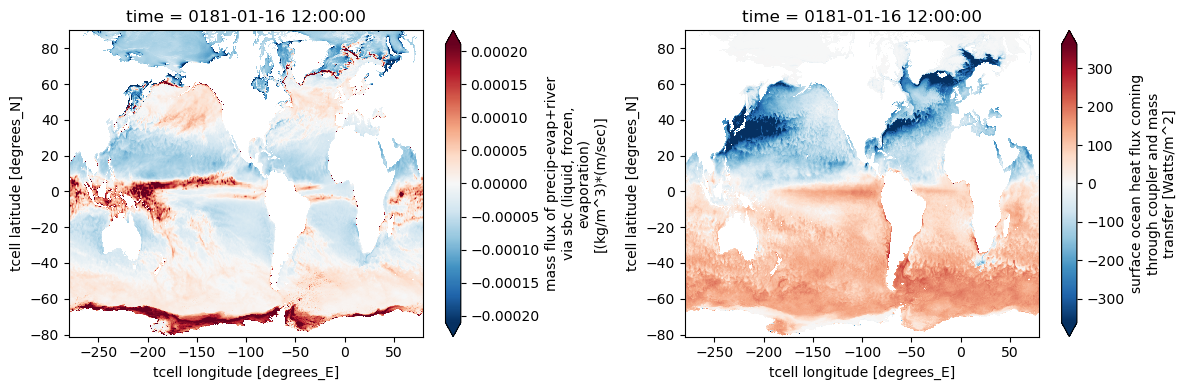

In [15]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

(ds.pme_river[0]).plot(ax=ax0, robust=True)
(ds.net_sfc_heating[0]).plot(ax=ax1, robust=True)
plt.tight_layout();

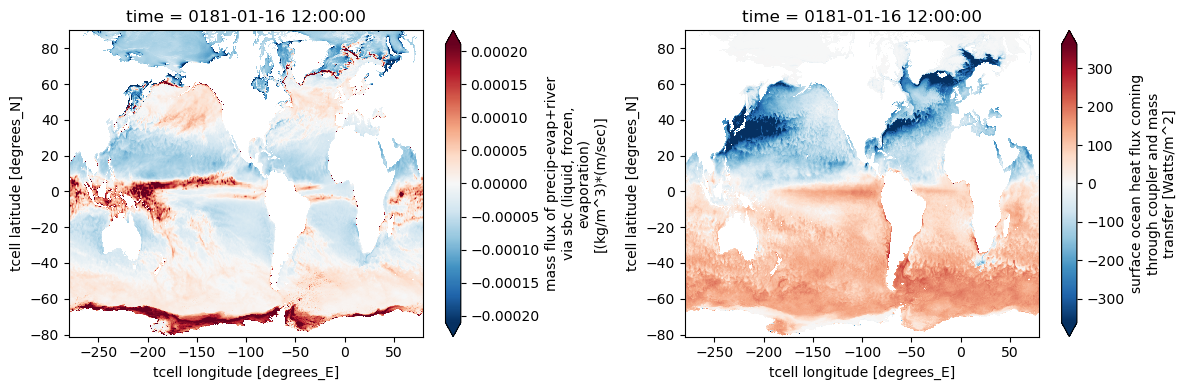

In [15]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

(ds.salt.isel(st_ocean=0)).plot(ax=ax0, robust=True)
(surf_ds.surface_salt).plot(ax=ax1, robust=True)
plt.tight_layout();

In [31]:
import pandas as pd

In [39]:
sss_resampled = sss.resample(time='MS', loffset=pd.Timedelta(15, 'd')).mean()
sst_resampled = sst.resample(time='MS', loffset=pd.Timedelta(15, 'd')).mean()

In [40]:
rho_const = 1027.1 #kg/m^3 got this value from argmax of the mean pdf 
heat_capacity = 3.994e3 #J/kg˚C

#surf salt flux
slt_flux = (ds.pme_river.where(coord.wet) * sss_resampled.where(coord.wet) * 
            coord.area_t.where(coord.wet)) / rho_const #psu m^3 / s

#surf heat flux
heat_flux = (ds.net_sfc_heating.where(coord.wet) * coord.area_t.where(coord.wet)) / (rho_const * heat_capacity) #˚C m^3 / s

In [44]:
drhods_resampled = drhods.resample(time='MS', loffset=pd.Timedelta(15, 'd')).mean()
drhodt_resampled = drhodt.resample(time='MS', loffset=pd.Timedelta(15, 'd')).mean()

In [45]:
tend_surf_salt = drhods_resampled * slt_flux
tend_surf_heat = drhodt_resampled * heat_flux
#Units: kg/s

In [46]:
surf_tend = xr.merge([tend_surf_salt.rename('surf_salt'), tend_surf_heat.rename('surf_heat')])

In [47]:
surf_tend

<xarray.Dataset>
Dimensions:    (xt_ocean: 3600, yt_ocean: 2700, time: 80)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time       (time) object 0181-04-16 00:00:00 ... 0200-11-16 00:00:00
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    surf_salt  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surf_heat  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

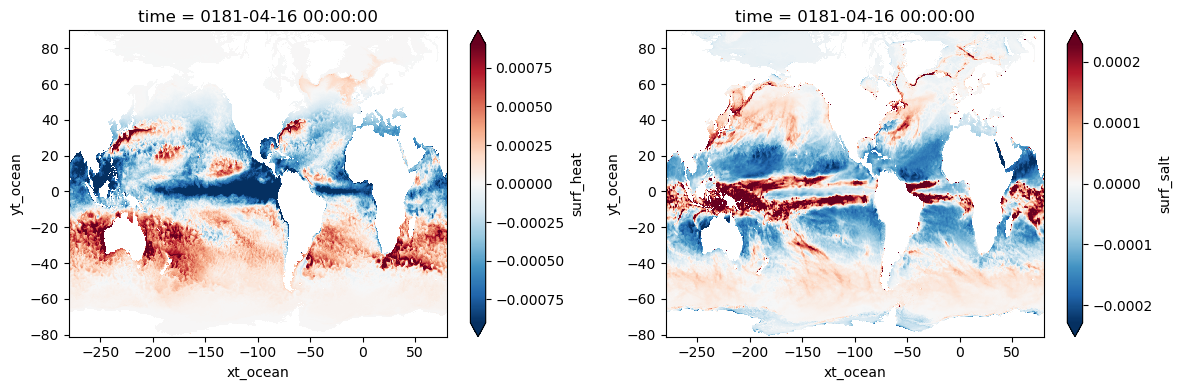

In [48]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

(surf_tend.surf_heat[0]/1e6).plot(robust=True, ax=ax0)
(surf_tend.surf_salt[0]/1e6).plot(robust=True, ax=ax1)
plt.tight_layout();

### Check if uploaded surf_tends match the aforementioned tends

In [54]:
uploaded_surf = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/surf_tendencies.zarr'))

In [ ]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

((uploaded_surf.surf_heat - surf_tend.surf_heat)[0]/1e6).plot(robust=True, ax=ax0)
((uploaded_surf.surf_salt - surf_tend.surf_salt)[0]/1e6).plot(robust=True, ax=ax1)
plt.tight_layout();

# Mask by basin

In [26]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-oarfvo93
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-oarfvo93
  Resolved https://github.com/mathause/regionmask.git to commit 048e2bbee3b5e3ef945139b8a957e8406c4b06df
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regionmask: filename=regionmask-0.9.0.post1.dev45+g048e2bb-py3-none-any.whl size=67327 sha256=472c6fe94ffcf732ba1202c382451ebb5fdaf2cb2af976d7a80d829d56480ab9
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ukwiqm8/wheels/1a/62/0f/f392f37f9bd2d2d61b9a6b63de17bb421b3f7c2972b03c9934
Successfully built regionmask


In [27]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-3m13tecd
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-3m13tecd
  Resolved https://github.com/jbusecke/xmip.git to commit 3bc0793f3bc7529a0e49da931e7d2465aa5eefd0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached xgcm-0.6.1-py3-none-any.whl (60 kB)
  Created wheel for xmip: filename=xmip-0.7.2.dev8+g3bc0793-py3-none-any.whl size=58754 sha256=b40e491ced1dd9c8c86979172d116df122b1cd0b57e1a2ce097182f682632b11
  Stored in directory: /tmp/pip-ephem-wheel-cache-7r2c13rf/wheels/14/81/1d/2382ef5c4df3bc79c5b5a3c37400af047e5a775a4b2cf79b42
Successfully built xmip
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.8.1
    Uninstalling xgcm-0.8.1:
      Successfully uninstalled xgcm-0.8.1
  Attempting uninstall: xmip
    Found existing installation: x

In [28]:
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask

<GeoAxes: >

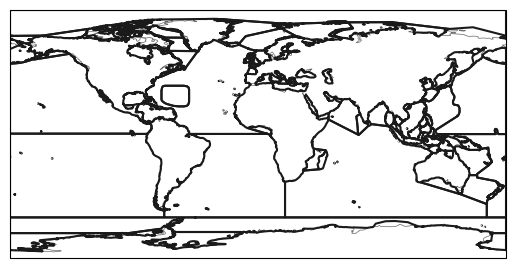

In [29]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [30]:
da = ds.temp.isel(time=0, st_ocean=0).squeeze()

In [31]:
da_renamed = da.rename({'geolat_t':'lat', 'geolon_t':'lon'}).load()

In [32]:
mask = merged_mask(basins, da_renamed)

/srv/conda/envs/notebook/lib/python3.10/site-packages/regionmask/core/mask.py:153: FutureWarning: Passing 'lon_name' and 'lat_name' is deprecated. Please pass the lon and lat coordinates direcly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/pygeos/io.py:523: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


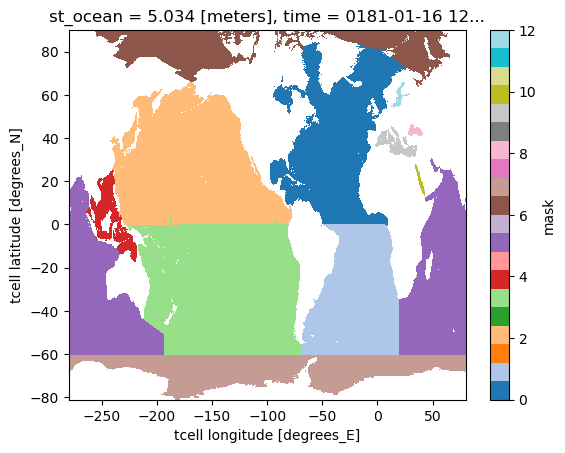

In [21]:
mask.plot(cmap='tab20');

In [33]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
south_china_seas = 4
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7
black_sea = 8
med_sea = 9
red_sea = 10
baltic_sea = 12 #no 11

In [18]:
#New ds after dthetadt*drhodt and dSdt*drhods
def new_ds(ds):
    newds = xr.merge([(ds['SST_lap']*ds['drhodt']).rename('sst'),
                      (ds['SSS_lap']*ds['drhods']).rename('sss'),
                       ds['rho_lap'],
                       ds['cabbeling']])
    return newds

In [19]:
tendencies = xr.merge([SST_lap.rename('SST_lap'), SSS_lap.rename('SSS_lap'),
                       drhodt.rename('drhodt'), drhods.rename('drhods'), 
                       rho_lap.drop(['geolon_t', 'geolat_t']).rename('rho_lap'), cabbeling.rename('cabbeling'),
                      rho.rename('rho')])
#tendencies = tendencies.drop(['st_ocean', 'geolat_t', 'geolon_t'])
tendencies = tendencies.drop(['geolat_t', 'geolon_t'])

In [20]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    SST_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SSS_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    drhodt     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    drhods     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [21]:
tend = new_ds(tendencies)

In [22]:
tend

<xarray.Dataset>
Dimensions:    (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    sst        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sss        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

# testing to see if uploaded tendencies close budget

In [20]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [21]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tracer_tendencies.zarr'))
#drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/drhodts_tendencies.zarr'))
#rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))
cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling.zarr'))
#rho_lap = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_laplacian.zarr'))

tendencies = xr.merge([tracers, cab])#, drhodts, rho_lap])

In [22]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    SSS_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SST_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

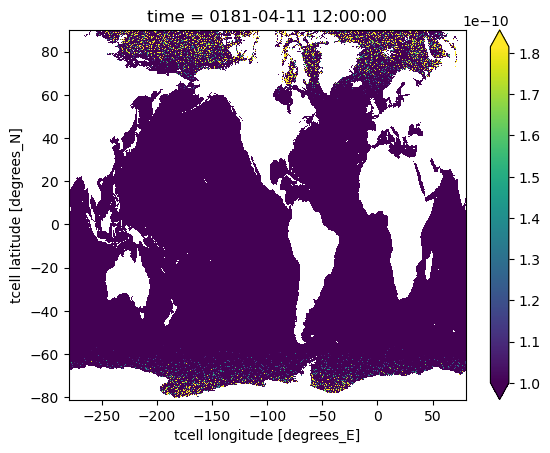

In [41]:
(rho_imported_lap - tendencies.SST_lap - tendencies.SSS_lap + tendencies.cabbeling).isel(time=100).plot(robust=True, vmin=1e-10);

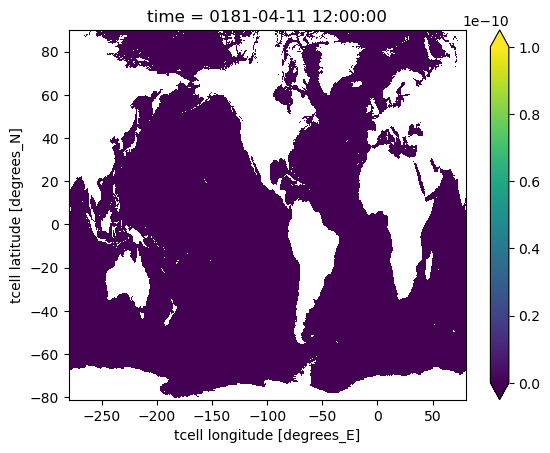

In [23]:
(rho_lap - tendencies.SST_lap - tendencies.SSS_lap + tendencies.cabbeling).isel(time=100).plot(robust=True, vmin=1e-10);

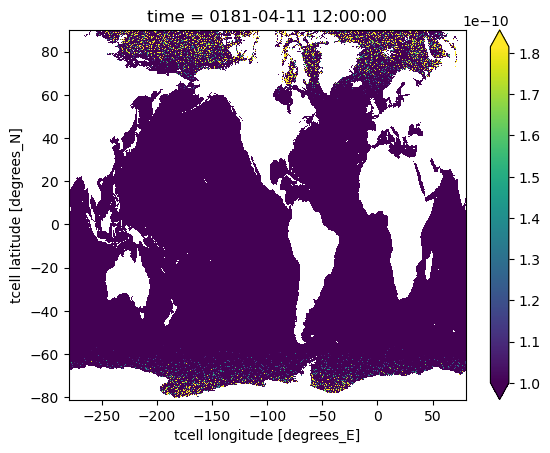

In [32]:
(tendencies.rho_lap - tend.sst - tend.sss + tend.cabbeling).isel(time=100).plot(robust=True, vmin=1e-10);

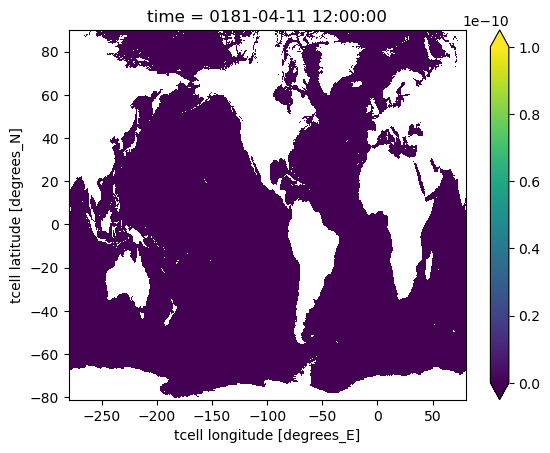

In [25]:
(tend.rho_lap - tend.sst - tend.sss + tend.cabbeling).isel(time=100).plot(robust=True, vmin=1e-10);

In [52]:
def basin_selection(tend_term, basin):
    tendency_in_basin = tend_term.where(mask==basin)
    return tendency_in_basin

### Surface part

In [41]:
all_surf = list(surf_tend)

In [42]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean_surf = xr.merge([basin_selection(surf_tend[var],
                                       north_atlantic_ocean).rename('NATL_' + var) for var in all_surf])
satl_ocean_surf = xr.merge([basin_selection(surf_tend[var], 
                                       south_atlantic_ocean).rename('SATL_' + var) for var in all_surf])

#Pacific Ocean
npac_ocean_surf = xr.merge([basin_selection(surf_tend[var], 
                                       north_pacific_ocean).rename('NPAC_' + var) for var in all_surf])
spac_ocean_surf = xr.merge([basin_selection(surf_tend[var], 
                                       south_pacific_ocean).rename('SPAC_' + var) for var in all_surf])

#Indian Ocean
ind_ocean_surf = xr.merge([basin_selection(surf_tend[var], indian_ocean).rename('IND_' + var) for var in all_surf])

#Arctic Ocean
arc_ocean_surf = xr.merge([basin_selection(surf_tend[var], arctic_ocean).rename('ARC_' + var) for var in all_surf])

#Southern Ocean
south_ocean_surf = xr.merge([basin_selection(surf_tend[var], 
                                        southern_ocean).rename('South_' + var) for var in all_surf])

In [43]:
natl_ocean_surf

<xarray.Dataset>
Dimensions:         (time: 240, xt_ocean: 3600, yt_ocean: 2700)
Coordinates: (12/14)
  * time            (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...              ...
    wet             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    st_ocean        float64 5.034
    geolat_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    lat             (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
    lon             (yt_ocean, xt_ocean) float32 nan nan nan nan ... nan nan nan
Data variables:
    NATL_surf_salt  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    NATL_surf_heat  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

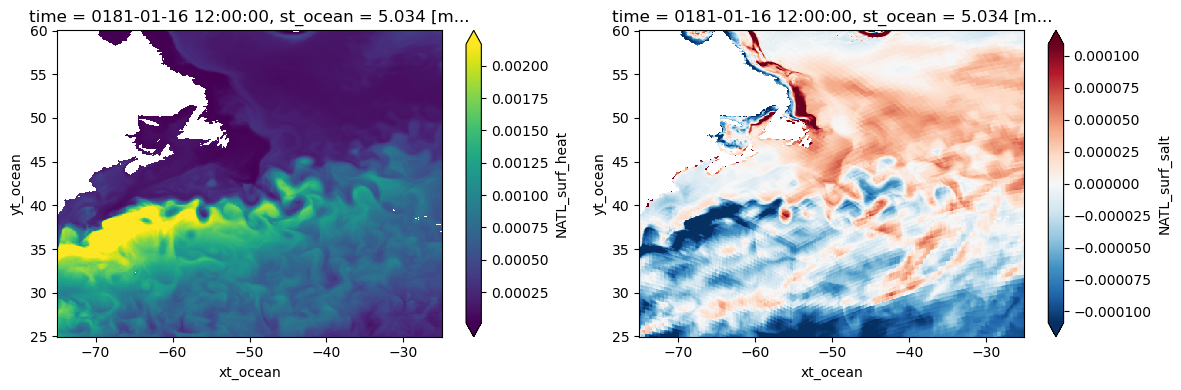

In [45]:
selection = dict(xt_ocean=slice(-75,-25), yt_ocean=slice(25,60))
kwargs = {'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'}

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))
(natl_ocean_surf.NATL_surf_heat.isel(time=0)/1e6).sel(**selection).plot(robust=True,ax=ax0)
(natl_ocean_surf.NATL_surf_salt.isel(time=0)/1e6).sel(**selection).plot(robust=True, ax=ax1)
plt.tight_layout();

### Mixing part

In [61]:
all_tendencies = list(tend)

In [62]:
#Atlantic Ocean - going to add 'NATL' prefix after adding natl_ocean+nor_sea+lab_sea respective vars
natl_ocean = xr.merge([basin_selection(tend[var],
                                       north_atlantic_ocean).rename('NATL_' + var) for var in all_tendencies])
satl_ocean = xr.merge([basin_selection(tend[var], 
                                       south_atlantic_ocean).rename('SATL_' + var) for var in all_tendencies])

#Pacific Ocean
npac_ocean = xr.merge([basin_selection(tend[var], 
                                       north_pacific_ocean).rename('NPAC_' + var) for var in all_tendencies])
spac_ocean = xr.merge([basin_selection(tend[var], 
                                       south_pacific_ocean).rename('SPAC_' + var) for var in all_tendencies])

#Indian Ocean
ind_ocean = xr.merge([basin_selection(tend[var], indian_ocean).rename('IND_' + var) for var in all_tendencies])

#Arctic Ocean
arc_ocean = xr.merge([basin_selection(tend[var], arctic_ocean).rename('ARC_' + var) for var in all_tendencies])

#Southern Ocean
south_ocean = xr.merge([basin_selection(tend[var], 
                                        southern_ocean).rename('South_' + var) for var in all_tendencies])

# Run histograms

In [63]:
rmask = mask
#mask_bins = np.arange(rmask.min()-0.5, rmask.max()+0.5)
mask_bins = np.array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 12.5, 99.5])
rho = rho # tendencies.rho
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)

In [64]:
avg_mld = ds.mld.mean('time').compute()
weights = coord.area_t*avg_mld

### Mixing part (histograms)

In [65]:
from xhistogram.xarray import histogram
def histogram_function(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(tendencies.rho.rename('rho0'), bins=[rho_bins],
                     weights=(ds[prefix+variable].fillna(0.)*(avg_mld*coord.area_t).where(mask==ocean).fillna(0.)),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

In [66]:
client.restart()

<Client: 'tls://10.0.63.19:8786' processes=0 threads=0, memory=0 B>

In [85]:
#mixing components
natl_hist = xr.merge([histogram_function(natl_ocean, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
satl_hist = xr.merge([histogram_function(satl_ocean, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
npac_hist = xr.merge([histogram_function(npac_ocean, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
spac_hist = xr.merge([histogram_function(spac_ocean, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_tendencies])
ind_hist = xr.merge([histogram_function(ind_ocean, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
arc_hist = xr.merge([histogram_function(arc_ocean, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_tendencies])
south_hist = xr.merge([histogram_function(south_ocean, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_tendencies])

#### Checking if global hist magnitude matches ryan's plot
Matches Ryan's fig when using the sst/sss diagnostics and setting constant mld to 50m.

In [37]:
global_rho_hist = histogram(rho.rename('rho0'), bins=[rho_bins], 
                            weights=(tend.rho_lap.fillna(0.)*(50*coord.area_t).fillna(0.)),
                           dim=['xt_ocean', 'yt_ocean']) / delta_rho

In [46]:
client.restart()

<Client: 'tls://10.0.6.19:8786' processes=0 threads=0, memory=0 B>

Task exception was never retrieved
future: <Task finished name='Task-663' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2134> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2143, in wait
    raise AllExit()
distributed.client.AllExit


(1015.0, 1029.0)

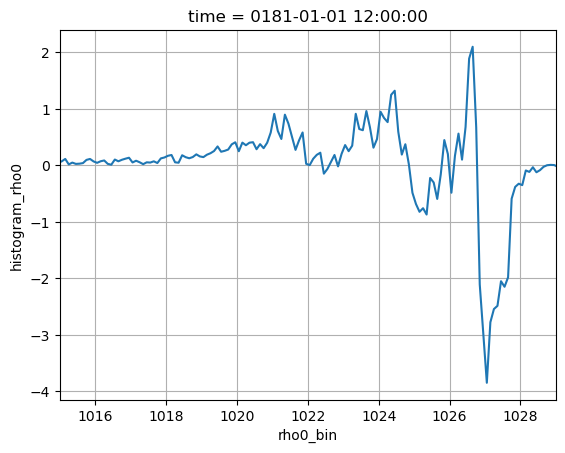

In [49]:
(global_rho_hist[0]/1e6).plot()
plt.grid()
plt.xlim(1015, 1029)

### Surface part (histograms)

In [52]:
#resample and interp rho to match surf_tend's time dim
rho_resampled = rho.resample(time='MS').mean().interp(time=surf_tend.time)

In [53]:
rho_resampled

<xarray.DataArray (time: 240, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(240, 2700, 3600), dtype=float32, chunksize=(240, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
    st_ocean  float64 5.034

In [54]:
from xhistogram.xarray import histogram
def histogram_function_surf(ds, prefix, ocean, variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho_resampled.rename('rho0'), bins=[rho_bins],
                     weights=ds[prefix+variable].fillna(0.),
                     dim=['xt_ocean', 'yt_ocean'])
    return hist / delta_rho

In [55]:
#surface fluxes
natl_hist_surf = xr.merge([histogram_function_surf(natl_ocean_surf, 'NATL_', north_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_surf])
satl_hist_surf = xr.merge([histogram_function_surf(satl_ocean_surf, 'SATL_', south_atlantic_ocean,
                                         var).rename('OMEGA_' + var) for var in all_surf])
npac_hist_surf = xr.merge([histogram_function_surf(npac_ocean_surf, 'NPAC_', north_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_surf])
spac_hist_surf = xr.merge([histogram_function_surf(spac_ocean_surf, 'SPAC_', south_pacific_ocean,
                                         var).rename('OMEGA_' + var) for var in all_surf])
ind_hist_surf = xr.merge([histogram_function_surf(ind_ocean_surf, 'IND_', indian_ocean,
                                        var).rename('OMEGA_' + var) for var in all_surf])
arc_hist_surf = xr.merge([histogram_function_surf(arc_ocean_surf, 'ARC_', arctic_ocean,
                                        var).rename('OMEGA_' + var) for var in all_surf])
south_hist_surf = xr.merge([histogram_function_surf(south_ocean_surf, 'South_', southern_ocean,
                                          var).rename('OMEGA_' + var) for var in all_surf])

In [56]:
natl_hist_surf

<xarray.Dataset>
Dimensions:          (time: 240, rho0_bin: 199)
Coordinates:
  * time             (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_surf_salt  (time, rho0_bin) float32 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_surf_heat  (time, rho0_bin) float32 dask.array<chunksize=(1, 199), meta=np.ndarray>

# Plot annual mean of histograms

In [86]:
def ann_mean2(ds):
    fig = plt.figure(figsize=(12,5))
    line_colors=['green', 'orange', 
                 'k', 'blue']#, 'purple', 'yellow'] #order of sst, sss, rho, cab, surf heat, surf salt
    for (i,j) in zip(list(ds.data_vars), line_colors):
        (ds[i].mean('time')/1e6).plot(label=f'{i}', color=j)
    plt.legend()
    #plt.ylim(-20,10)
    plt.ylabel(r'Transformation (Sv)', fontsize=16)
    plt.grid()
    plt.title('Annual Mean Transformation Terms', fontsize=20);

In [87]:
client.restart()

<Client: 'tls://10.0.63.12:8786' processes=0 threads=0, memory=0 B>

In [88]:
natl_hist.nbytes/1e9

0.046578272

In [89]:
natl_hist

<xarray.Dataset>
Dimensions:          (time: 7305, rho0_bin: 199)
Coordinates:
  * time             (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_SSS_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_SST_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

In [ ]:
client.close()
cluster.close()

In [96]:
ann_mean2(natl_hist)

KeyboardInterrupt: 

<Figure size 1200x500 with 0 Axes>

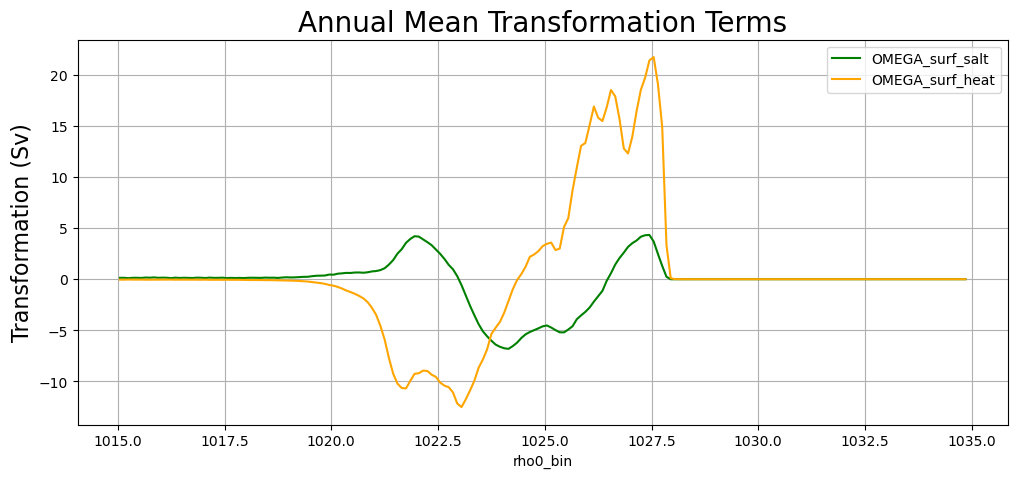

In [51]:
ann_mean2(natl_hist_surf)

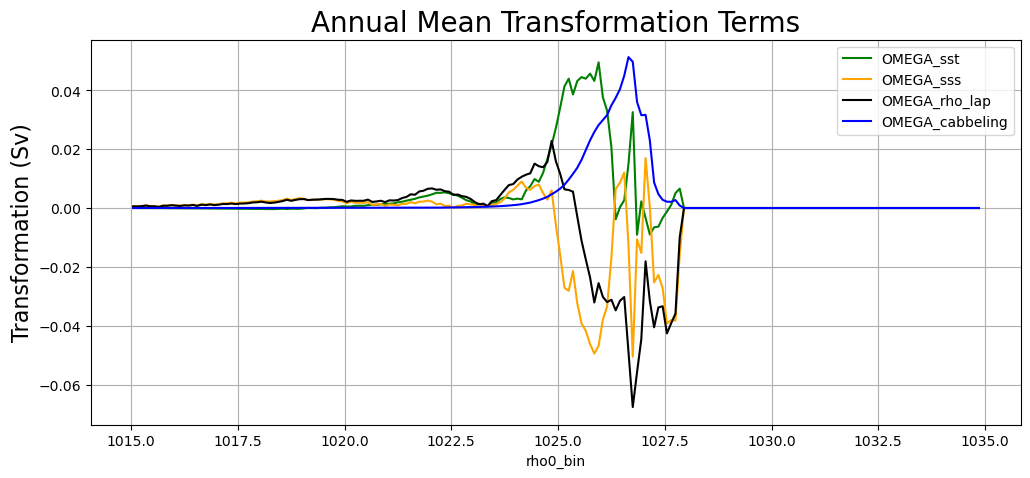

In [49]:
ann_mean2(satl_hist)

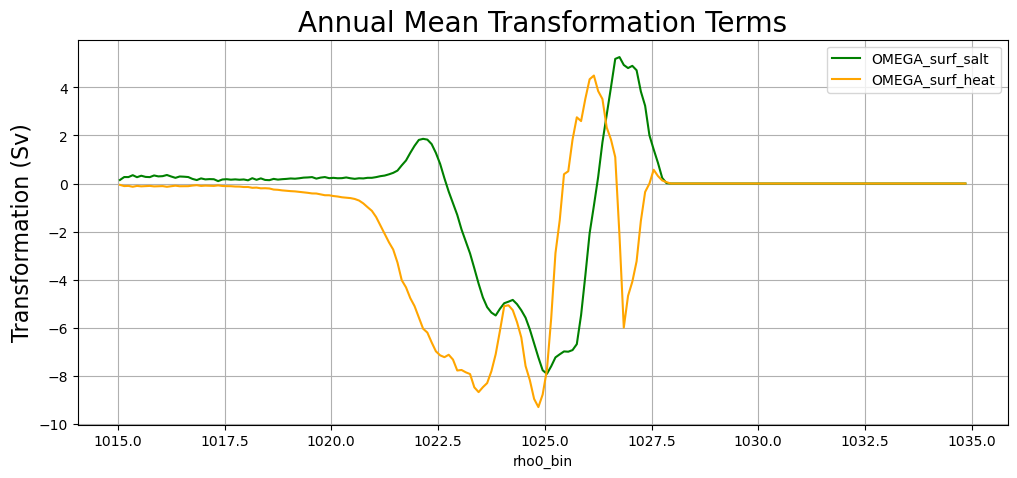

In [52]:
ann_mean2(satl_hist_surf)

## 4) Save the four terms to dataset <a class="anchor" id="fourth-bullet"> </a>

In [53]:
client.restart()

<Client: 'tls://10.0.71.18:8786' processes=0 threads=0, memory=0 B>

### Save surface tend terms

In [61]:
hist_names = list(['natl_ocean_surf', 'satl_ocean_surf', 'npac_ocean_surf', 
                   'spac_ocean_surf', 'arc_ocean_surf', 'south_ocean_surf', 'ind_ocean_surf'])
hist_ds = list([natl_ocean_surf, satl_ocean_surf, npac_ocean_surf, 
                spac_ocean_surf, arc_ocean_surf, south_ocean_surf, ind_ocean_surf])

In [62]:
def save_to_zarr_tendencies(ds, names):
    "Save all the basin histograms to zarr"
    ds.to_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/surf/' + names + '_tends.zarr'),
               mode='w')

In [51]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [64]:
#save surf tend datasets to zarr
for (i,j) in zip(hist_ds, hist_names):
    save_to_zarr_tendencies(i, j)

In [49]:
surf_tend

<xarray.Dataset>
Dimensions:    (xt_ocean: 3600, yt_ocean: 2700, time: 80)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time       (time) object 0181-04-16 00:00:00 ... 0200-11-16 00:00:00
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    surf_salt  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surf_heat  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [52]:
#uploading global surf_tend
gcsmap_surf_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/surf_tendencies.zarr')
surf_tend.to_zarr(gcsmap_surf_tendencies, mode='w')

### Save mixing tend terms

In [27]:
tracers = xr.merge([tendencies.SST_lap.rename('SST_lap'), 
                    tendencies.SSS_lap.rename('SSS_lap')])
drhodts = xr.merge([tendencies.drhodt.rename('drhodt'), 
                    tendencies.drhods.rename('drhods')])
rho_lap_cab = xr.merge([tendencies.rho_lap.rename('rho_lap'),
                        tendencies.rho.rename('rho'),
                        tendencies.cabbeling.rename('cabbeling')])

In [26]:
tracers = xr.merge([tend.sst.rename('SST_lap'), 
                    tend.sss.rename('SSS_lap')])
cab = tend.cabbeling.to_dataset(name='cabbeling')
rho_lap = tend.rho_lap.to_dataset(name='rho_lap')

In [25]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [24]:
rho_lap_ds = rho_lap.to_dataset(name='rho_lap')

In [43]:
tracers

<xarray.Dataset>
Dimensions:   (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    SST_lap   (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SSS_lap   (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [35]:
client.restart()

<Client: 'tls://10.0.63.23:8786' processes=27 threads=54, memory=810.00 GiB>

In [36]:
#uploading tracer tendency ds for entire 40 yr run
gcsmap_tracer_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tracer_tendencies.zarr')
tracers.to_zarr(gcsmap_tracer_tendencies, mode='w')

Task exception was never retrieved
future: <Task finished name='Task-3138' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2134> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2143, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-3347' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2134> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2143, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-3346' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/pyth

In [26]:
client.restart()

<Client: 'tls://10.0.63.23:8786' processes=27 threads=54, memory=810.00 GiB>

In [38]:
cab

<xarray.Dataset>
Dimensions:    (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [39]:
#uploading cabbeling tendency ds for entire 40 yr run
gcsmap_cab_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling.zarr')
cab.to_zarr(gcsmap_cab_tendencies, mode='w')

In [41]:
client.restart()

<Client: 'tls://10.0.63.23:8786' processes=29 threads=58, memory=870.00 GiB>

In [48]:
rho_lap.isel(time=slice(0,3652))

<xarray.Dataset>
Dimensions:   (time: 3652, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0190-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    rho_lap   (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [49]:
rho_lap.isel(time=slice(3652,-1))

<xarray.Dataset>
Dimensions:   (time: 3652, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time      (time) object 0191-01-01 12:00:00 ... 0200-12-30 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    rho_lap   (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [42]:
rho_lap

<xarray.Dataset>
Dimensions:   (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    rho_lap   (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [ ]:
#uploading rho_lap tendency ds first half
gcsmap_rho_lap = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_lap_first_half.zarr')
rho_lap_ds.isel(time=slice(0,3652)).to_zarr(gcsmap_rho_lap, mode='w')

In [ ]:
#uploading rho_lap tendency ds second half
gcsmap_rho_lap = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_lap_second_half.zarr')
rho_lap.isel(time=slice(3652, -1)).to_zarr(gcsmap_rho_lap, mode='w')

In [72]:
client.restart()

<Client: 'tls://10.0.63.19:8786' processes=0 threads=0, memory=0 B>

In [73]:
#uploading drhodts tendency ds for entire 40 yr run
gcsmap_drhodts_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/drhodts_tendencies.zarr')
drhodts.to_zarr(gcsmap_drhodts_tendencies, mode='w')

In [27]:
cab = cabbeling.to_dataset(name='cabbeling')
rho_ds = rho.to_dataset(name='rho')
rho_lap_ds = rho_imported_lap.to_dataset(name='rho_lap')

In [70]:
cab

<xarray.Dataset>
Dimensions:    (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [39]:
#uploading cabbeling tendency ds for entire 40 yr run
gcsmap_cab_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling.zarr')
cab.to_zarr(gcsmap_cab_tendencies, mode='w')

In [ ]:
client.restart()

In [18]:
rho_lap_ds

<xarray.Dataset>
Dimensions:   (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    rho_lap   (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [19]:
#uploading rho_bih tendency ds for entire 40 yr run
gcsmap_rho_lap = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_laplacian.zarr')
rho_lap_ds.to_zarr(gcsmap_rho_lap, mode='w')

In [34]:
client.restart()

<Client: 'tls://10.0.63.23:8786' processes=27 threads=54, memory=810.00 GiB>

In [31]:
rho_ds = rho.to_dataset(name='rho')

In [35]:
rho_ds

<xarray.Dataset>
Dimensions:   (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    rho       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

In [36]:
#uploading rho ds for entire 40 yr run
gcsmap_rho = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr')
rho_ds.to_zarr(gcsmap_rho, mode='w')

## 4) Save the histograms by basin

In [78]:
client.restart()

<Client: 'tls://10.0.12.6:8786' processes=26 threads=52, memory=780.00 GiB>

### Save Mixing histogram terms

In [90]:
hist_names = list(['natl_hist', 'satl_hist', 'npac_hist', 'spac_hist', 'arc_hist', 'south_hist', 'ind_hist'])
hist_ds = list([natl_hist, satl_hist, npac_hist, spac_hist, arc_hist, south_hist, ind_hist])

In [91]:
def test(ds, names):
    "Save all the basin histograms to zarr"
    print(f'pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/' + names + '.zarr')

In [92]:
for (i,j) in zip(hist_ds, hist_names):
    test(i, j)

pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/natl_hist.zarr
pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/satl_hist.zarr
pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/npac_hist.zarr
pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/spac_hist.zarr
pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/arc_hist.zarr
pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/south_hist.zarr
pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/ind_hist.zarr


In [93]:
def save_to_zarr(ds, names):
    "Save all the basin histograms to zarr"
    ds.to_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/' + names + '.zarr'),
               mode='w')

In [94]:
#save histogram datasets to zarr
for (i,j) in zip(hist_ds, hist_names):
    save_to_zarr(i, j)

In [95]:
client.restart()

<Client: 'tls://10.0.63.12:8786' processes=0 threads=0, memory=0 B>

### Save surface histogram terms

In [31]:
hist_names = list(['natl_hist_surf', 'satl_hist_surf', 'npac_hist_surf', 
                   'spac_hist_surf', 'arc_hist_surf', 'south_hist_surf', 'ind_hist_surf'])
hist_ds = list([natl_hist_surf, satl_hist_surf, npac_hist_surf, 
                spac_hist_surf, arc_hist_surf, south_hist_surf, ind_hist_surf])

In [32]:
def save_to_zarr(ds, names):
    "Save all the basin histograms to zarr"
    ds.to_zarr(gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/CM2_6/datasets/basin-histograms/surf_ds/' + names + '.zarr'),
               mode='w')

In [33]:
client.restart()

<Client: 'tls://10.0.71.20:8786' processes=0 threads=0, memory=0 B>

In [35]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [36]:
#save histogram datasets to zarr
for (i,j) in zip(hist_ds, hist_names):
    save_to_zarr(i, j)

In [59]:
cluster.close()
client.close()